In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error, f1_score, cohen_kappa_score, matthews_corrcoef, classification_report
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,BaggingRegressor,BaggingClassifier, \
AdaBoostRegressor,AdaBoostClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pyearth import Earth
import itertools as it
import time as time
import xgboost as xgb
import re 

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

Our dataset originates from https://archive.ics.uci.edu/ml/datasets/Wine+Quality

To find the dataset below, click on "Data Folder" and then "winequality-white.csv".

In [8]:
# Load in the original dataset for white wine
df = pd.read_csv('winequality-white.csv', sep=';')

### Distribution of response
*By Sylvia Sherwood*

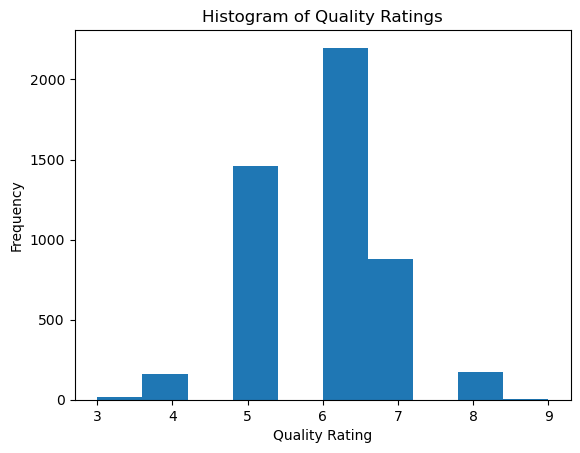

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


In [9]:
# Histogram for the distribution of the response (quality)
plt.hist(df['quality'], bins=10)
plt.title('Histogram of Quality Ratings')
plt.xlabel('Quality Rating')
plt.ylabel('Frequency')
plt.show()

# Summary statistics, including mean and standard deviation, of response #
print(df.quality.describe())

### Data cleaning
*By Sankaranarayanan Balasubramanian & Fiona Fe*

No data cleaning was necessary since there were no missing values and the structure/data types of the response and predictors were usuable for our models (see code below)

In [10]:
# Checking the structure and data types
print(df.info())

# Checking for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides        

### Data preparation
*By Ryu Kimiko*

To prepare our data for analysis, we split the data into train and test sets, 
The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We split our data into a training and test set so that we could tune the hyperparameters for each model using the train set, and then test our models on the test set. However, when splitting, we stratified according to the response to account for the imbalance in the class dataset and ensure that the training and testing sets have similar distributions of the target variable, which can lead to more accurate and reliable model performance estimates.

2. We standardized our dataset to account for the different ranges of the predictors in the dataset.

In [11]:
# Define the features and the target
X = df.drop('quality', axis=1)
y = df['quality']

# Split the data into train and test sets, with stratification on the 'quality' column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the distribution of 'quality' in the whole dataset, the training set and the test set
print("Whole dataset:\n", y.value_counts(normalize=True))
print("\nTraining set:\n", y_train.value_counts(normalize=True))
print("\nTest set:\n", y_test.value_counts(normalize=True))

Whole dataset:
 6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

Training set:
 6    0.448698
5    0.297601
7    0.179684
8    0.035733
4    0.033180
3    0.004084
9    0.001021
Name: quality, dtype: float64

Test set:
 6    0.448980
5    0.296939
7    0.179592
8    0.035714
4    0.033673
3    0.004082
9    0.001020
Name: quality, dtype: float64


## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Decision Tree
*By Aarti Pappu*

First, I started with a basic model to better understand the ranges of the different hyperparameters of the decision tree so I could know where to start my tuning.

In [13]:
# Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X_train, y_train)

print("Maximum number of leaves:", model.get_n_leaves())
print("Maximum depth:", model.get_depth())
print("Maximum features:", len(X_train.columns))

Maximum number of leaves: 1037
Maximum depth: 25
Maximum features: 11


Using the hyperparameter ranges obtained, as well as my intuition about other hyperparameters that could be important in tuning the tree (`min_samples_leaf` and `min_samples_split`), I did a course grid search to try to narrow the range of the optimal hyperparameters. I then plotted the results of the coarse grid search to better understand the ranges of the optimal hyperparameters.

In [14]:
# Coarse grid search parameter grid
param_grid = {    
    'criterion':['gini','entropy'],
    'max_depth': range(2,26,5),
    'max_leaf_nodes': range(2,1038,100),
    'max_features': range(1, 12,3),
    'min_samples_leaf': range(1,10,2),
    'min_samples_split': range(2,10,2)
}

# Using 2-fold CV because of the limited number of instances of some of the classes 
skf = StratifiedKFold(n_splits=2)

# Aiming to maximize F1-score
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# Make the predictions
y_pred = grid_search.predict(X_test)

print('Train F1-score : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test F1-score : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best F1-score Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for F1-score')
print(grid_search.best_params_)

Fitting 2 folds for each of 8800 candidates, totalling 17600 fits
Train F1-score : 0.882
Test F1-score : 0.571
Best F1-score Through Grid Search : 0.542
Best params for F1-score
{'criterion': 'entropy', 'max_depth': 22, 'max_features': 4, 'max_leaf_nodes': 702, 'min_samples_leaf': 1, 'min_samples_split': 2}


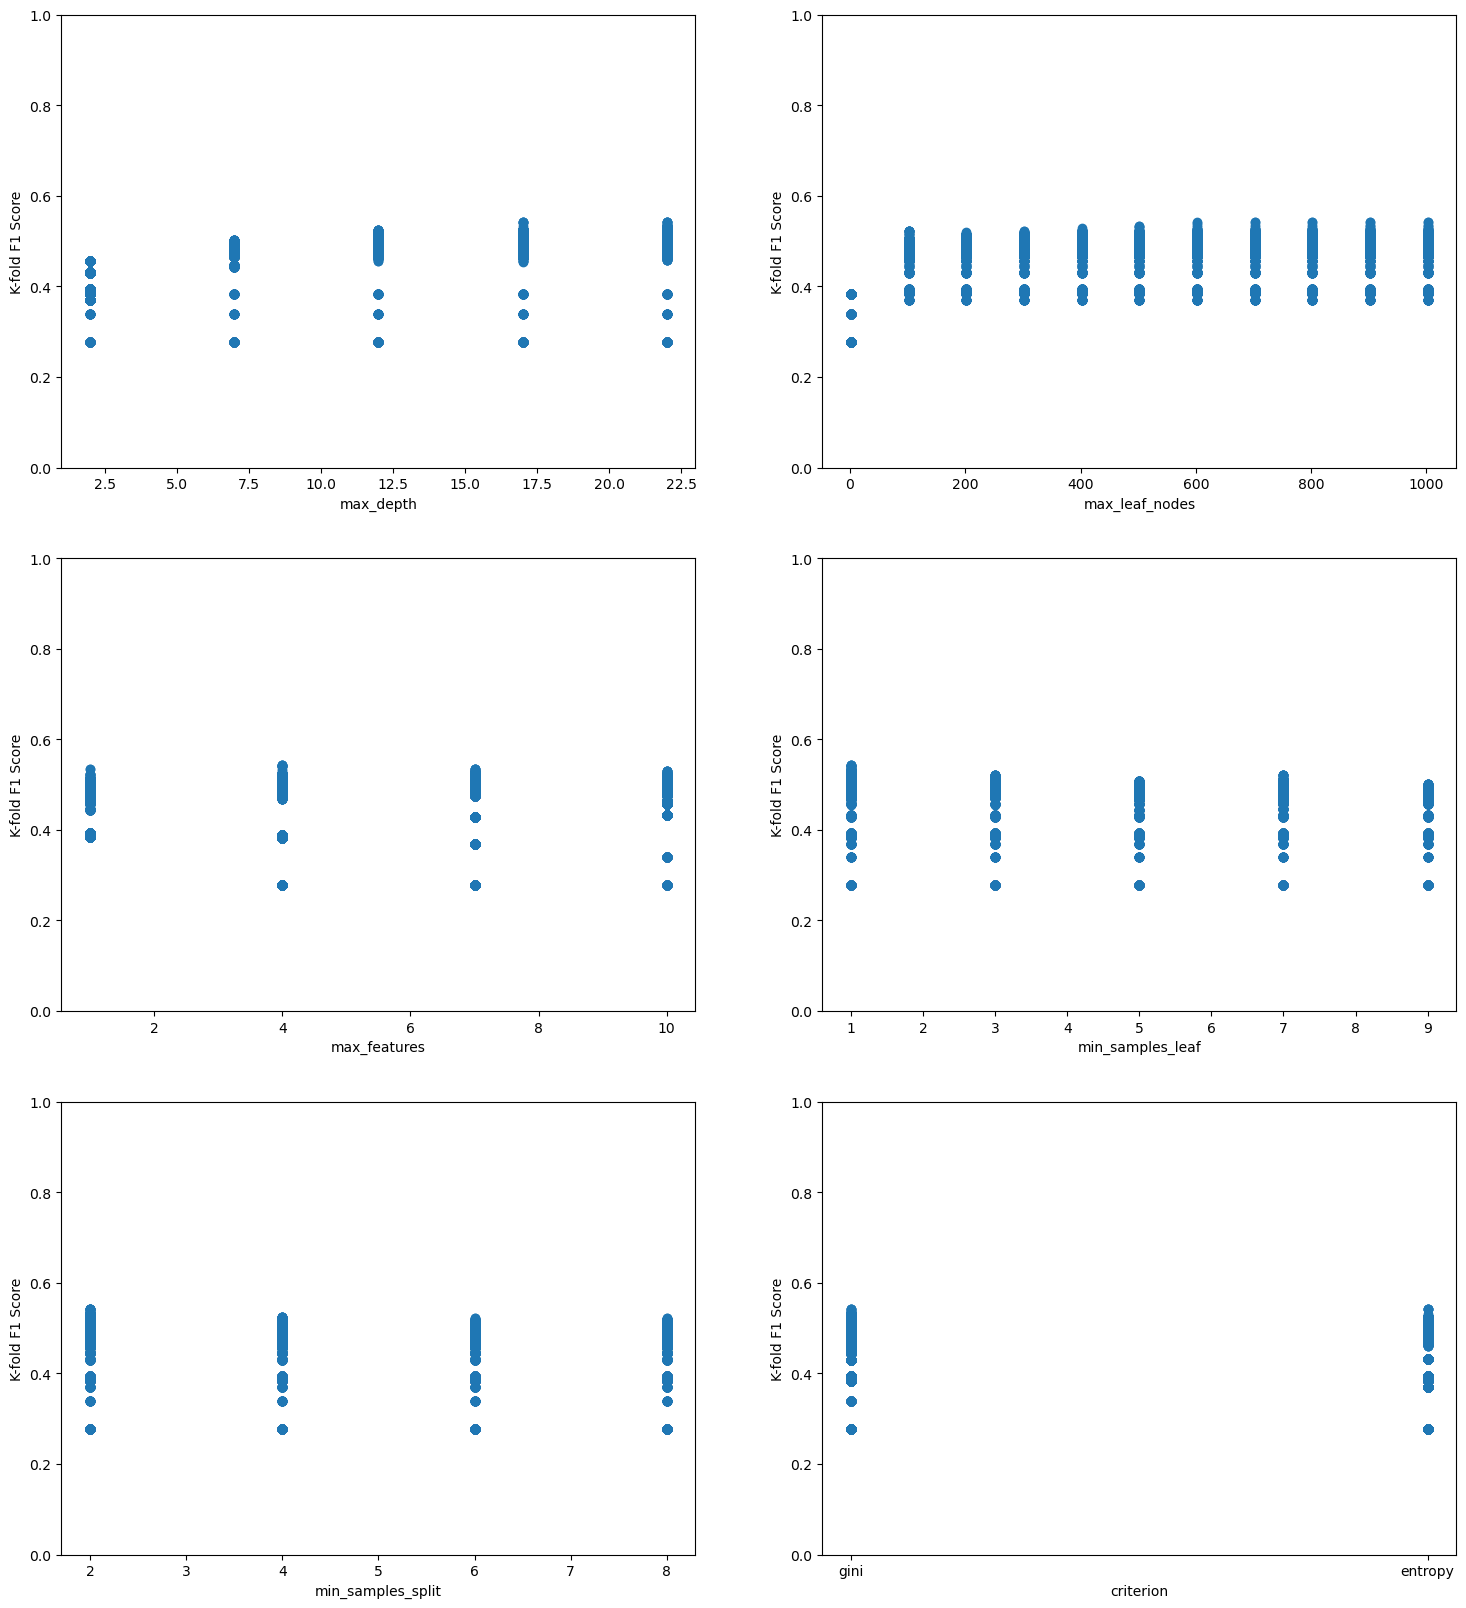

In [15]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,2,figsize=(18,20))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results.param_max_depth, cv_results.mean_test_f1_weighted, 'o')
axes[0,0].set_ylim([0,1])
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('K-fold F1 Score')
axes[0,1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_f1_weighted, 'o')
axes[0,1].set_ylim([0,1])
axes[0,1].set_xlabel('max_leaf_nodes')
axes[0,1].set_ylabel('K-fold F1 Score')
axes[1,0].plot(cv_results.param_max_features, cv_results.mean_test_f1_weighted, 'o')
axes[1,0].set_ylim([0,1])
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('K-fold F1 Score')
axes[1,1].plot(cv_results.param_min_samples_leaf, cv_results.mean_test_f1_weighted, 'o')
axes[1,1].set_ylim([0,1])
axes[1,1].set_xlabel('min_samples_leaf')
axes[1,1].set_ylabel('K-fold F1 Score')
axes[2,0].plot(cv_results.param_min_samples_split, cv_results.mean_test_f1_weighted, 'o')
axes[2,0].set_ylim([0,1])
axes[2,0].set_xlabel('min_samples_split')
axes[2,0].set_ylabel('K-fold F1 Score')
axes[2,1].plot(cv_results.param_criterion, cv_results.mean_test_f1_weighted, 'o')
axes[2,1].set_ylim([0,1])
axes[2,1].set_xlabel('criterion')
axes[2,1].set_ylabel('K-fold F1 Score');

Since it was clear that the optimal value of `min_samples_split` and `min_samples_leaf` were their default values (2 and 1 respectively), I did not further tune these values. However, I was uncertain about the optimal values of the remaining hyperparameters, so I decided to do a finer grid search, narrowing down the ranges for each hyperparameter based on the above graphs.

In [16]:
# Finer grid search
param_grid = {    
    'criterion':['gini','entropy'],
    'max_depth': range(8,26,2),
    'max_leaf_nodes': range(100,1038,50),
    'max_features': range(1,12,2)
}

# Using 2-fold CV because of the limited number of instances of some of the classes 
skf = StratifiedKFold(n_splits=2)

# Aiming to maximize F1-score
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# Make the predictions
y_pred = grid_search.predict(X_test)

print('Train F1-score : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test F1-score : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best F1-score Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for F1-score')
print(grid_search.best_params_)

Fitting 2 folds for each of 2052 candidates, totalling 4104 fits
Train F1-score : 0.846
Test F1-score : 0.535
Best F1-score Through Grid Search : 0.540
Best params for F1-score
{'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'max_leaf_nodes': 600}


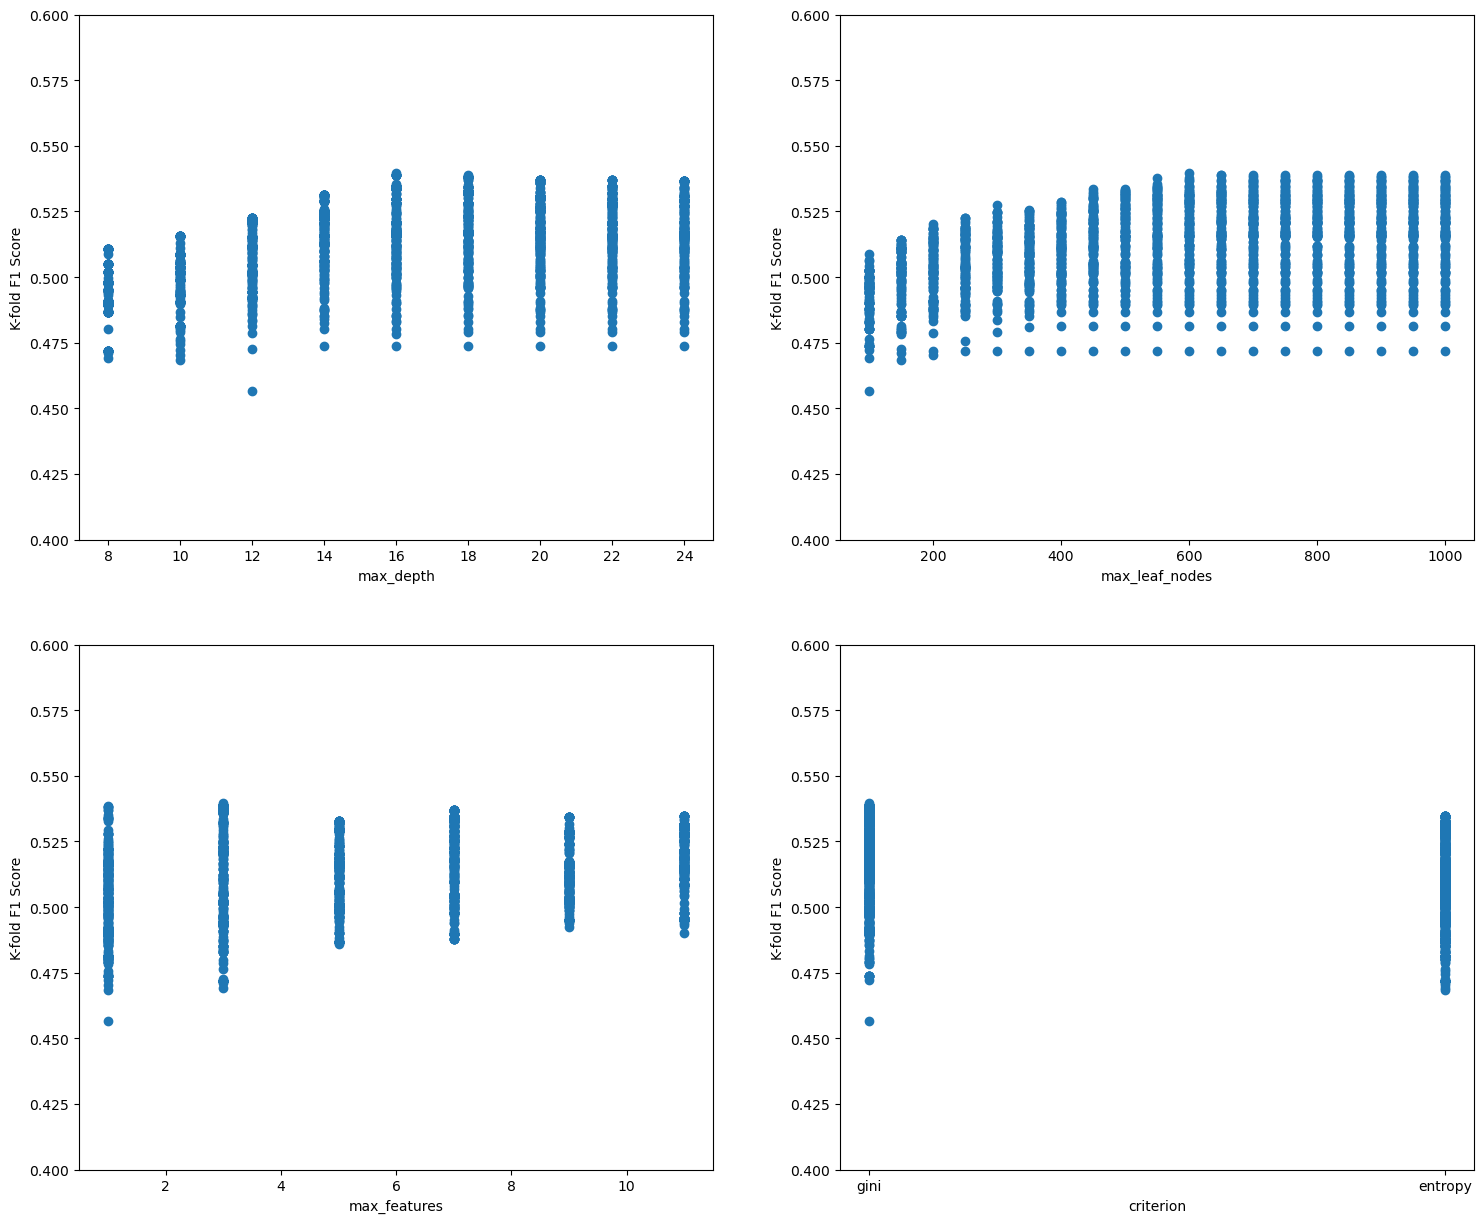

In [17]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(2,2,figsize=(18,15))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results.param_max_depth, cv_results.mean_test_f1_weighted, 'o')
axes[0,0].set_ylim([0.4,0.6])
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('K-fold F1 Score')
axes[0,1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_f1_weighted, 'o')
axes[0,1].set_ylim([0.4,0.6])
axes[0,1].set_xlabel('max_leaf_nodes')
axes[0,1].set_ylabel('K-fold F1 Score')
axes[1,0].plot(cv_results.param_max_features, cv_results.mean_test_f1_weighted, 'o')
axes[1,0].set_ylim([0.4,0.6])
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('K-fold F1 Score')
axes[1,1].plot(cv_results.param_criterion, cv_results.mean_test_f1_weighted, 'o')
axes[1,1].set_ylim([0.4,0.6])
axes[1,1].set_xlabel('criterion')
axes[1,1].set_ylabel('K-fold F1 Score');

Since it seemed clear that `gini` was the optimal `criterion`, I decided to only further tune the remaining hyperparameters (`max_depth`, `max_leaf_nodes`, and `max_features`) in order to find the optimal hyperparameter values.

In [18]:
# Finer grid search
param_grid = { 
    'max_depth': range(16,26),
    'max_leaf_nodes': range(550,1038),
    'max_features': range(1,5)
}

# Using 2-fold CV because of the limited number of instances of some of the classes 
skf = StratifiedKFold(n_splits=2)

# Aiming to maximize F1-score
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'f1_weighted', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# Make the predictions
y_pred = grid_search.predict(X_test)

print('Train F1-score : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test F1-score : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best F1-score Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for F1-score')
print(grid_search.best_params_)

Fitting 2 folds for each of 19520 candidates, totalling 39040 fits
Train F1-score : 0.864
Test F1-score : 0.557
Best F1-score Through Grid Search : 0.542
Best params for F1-score
{'max_depth': 17, 'max_features': 4, 'max_leaf_nodes': 613}


Based on the optimal hyperparameters found through the grid searches, I got an optimal model:

In [19]:
# Decision tree classifier with the optimal parameters
dt_model = DecisionTreeClassifier(random_state=1, max_depth=17, max_features = 4, max_leaf_nodes=613)
dt_model.fit(X_train,y_train)

# Getting the feature importances of the model
feature_importance_df = pd.concat([pd.Series(model.feature_names_in_), pd.Series(dt_model.feature_importances_)], axis = 1)
feature_importance_df.rename(columns={0: "predictors", 1: "feature_importance"}).sort_values(by='feature_importance', ascending=False)

,predictors,feature_importance
7,density,0.137988
1,volatile acidity,0.109337
10,alcohol,0.104010
3,residual sugar,0.098156
8,pH,0.094459
0,fixed acidity,0.086861
2,citric acid,0.080260
9,sulphates,0.075553
5,free sulfur dioxide,0.075066
6,total sulfur dioxide,0.073783


In [20]:
# Predict the labels of the test set using the optimal model
y_pred = dt_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.21      0.21      0.21        33
           5       0.59      0.60      0.60       291
           6       0.58      0.60      0.59       440
           7       0.52      0.49      0.50       176
           8       0.44      0.34      0.39        35
           9       0.00      0.00      0.00         1

    accuracy                           0.56       980
   macro avg       0.34      0.32      0.33       980
weighted avg       0.55      0.56      0.55       980

[[  0   0   1   3   0   0   0]
 [  0   7  15  10   1   0   0]
 [  1  12 176  91  10   1   0]
 [  1  10  94 265  62   8   0]
 [  0   1   9  74  86   6   0]
 [  0   3   4  11   5  12   0]
 [  0   0   0   0   1   0   0]]


/Users/aartipappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aartipappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aartipappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bagged Decision Trees
*By Divya Bhardwaj*

### Random Forest
*By Diego Schummer*

### XGBoost
*By Yasmeen Nahas*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble - Hard Voting
*By Aarti Pappu*

In [21]:
#Voting ensemble: Averaging the predictions of all models
voting_ensemble = VotingClassifier(estimators = [('dt',dt_model),('bg',bg_model),('rf',rf_model),('xgb',xgb_model)])
voting_ensemble.fit(X_train,y_train)
voting_pred = voting_ensemble.predict(X_test)
print(classification_report(y_test, voting_pred))
print(confusion_matrix(y_test, voting_pred))

NameError: name 'VotingClassifier' is not defined

### Stacking ensemble(s)
*By Aarti Pappu*

In [ ]:
#Using Logistic regression as the meta model (final_estimator)
stacking_ensemble = StackingClassifier(estimators=[('dt',dt_model),('bg',bg_model),('rf',rf_model),('xgb',xgb_model)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=1))
stacking_ensemble.fit(X_train,y_train)
stacking_pred = stacking_ensemble.predict(X_test)
print(classification_report(y_test, stacking_pred))
print(confusion_matrix(y_test, stacking_pred))

### Ensemble of ensembled models (using stacking ensemble)
*By Aarti Pappu*

In [ ]:
#Using Logistic regression as the meta model (final_estimator)
ensemble_model = StackingClassifier(estimators=[('voting',voting_ensemble),('stacking',stacking_ensemble)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=1))
ensemble_model.fit(X_train,y_train)
ensemble_model.score(X_test, y_test)

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.